### import necessary package

In [52]:
import sys

import pywt

sys.path.append('../')

import torch
import numpy as np
import PIL.Image
import torchvision
from torchvision.transforms.transforms import ToTensor, Resize, Compose
import matplotlib.pyplot as plt
from tools.img import tensor2ndarray, ndarray2tensor, fft_2d_3c, ifft_2d_3c
from tools.img import dct_2d_3c_full_scale, idct_2d_3c_full_scale, dct_2d_3c_slide_window, idct_2d_3c_slide_window

torch.manual_seed(42)

### load clean image $x_c$ and trigger image $x_p$

In [53]:
x_p_img = PIL.Image.open('../resource/DUBA/64.png')
scale = 224
ds = torchvision.datasets.Imagenette(root='../data', transform=Compose([Resize((scale, scale))]))

def get_trans(size: int):
    return Compose([Resize((size, size)), np.array])

x_p = get_trans(scale)(x_p_img).astype(float) / 255.
x_c = get_trans(scale)(ds[1][0]) / 255.

type(x_c), x_c.shape

(numpy.ndarray, (224, 224, 3))

### stage 1, mix high-frequency as trigger on original clean image

In [54]:
from tools.img import dwt_2d_3c, idwt_2d_3c
alpha = beta = 0.4

L_0 = x_c
L_1, (H_11, H_12, H_13) = dwt_2d_3c(L_0)
L_2, (H_21, H_22, H_23) = dwt_2d_3c(L_1 / 2.)
x_p1 = get_trans(L_1.shape[0])(x_p_img) / 255.
# L_1.shape
LP_1, (HP_11, HP_12, HP_13) = dwt_2d_3c(x_p1)
H_21 = beta * H_21 + (1 - beta) * HP_11
H_22 = beta * H_22 + (1 - beta) * HP_12
H_23 = beta * H_23 + (1 - beta) * HP_13

L_3, (H_31, H_32, H_33) = dwt_2d_3c(L_2 / 2.)
x_p2 = get_trans(L_2.shape[0])(x_p_img) / 255.
# x_p2.shape
LP_2, (HP_21, HP_22, HP_23) = dwt_2d_3c(x_p2)
H_31 = alpha * H_31 + (1 - alpha) * HP_21
H_32 = alpha * H_32 + (1 - alpha) * HP_22
H_33 = alpha * H_33 + (1 - alpha) * HP_23

L_2 = idwt_2d_3c(coeffs=[L_3, (H_31, H_32, H_33)]).astype(float) * 2.
L_1 = idwt_2d_3c(coeffs=[L_2, (H_21, H_22, H_23)]).astype(float) * 2
L_0 = idwt_2d_3c(coeffs=[L_1, (H_11, H_12, H_13)]).astype(float)

P_i = L_0
P_i.shape

(224, 224, 3)

### plot tmp results

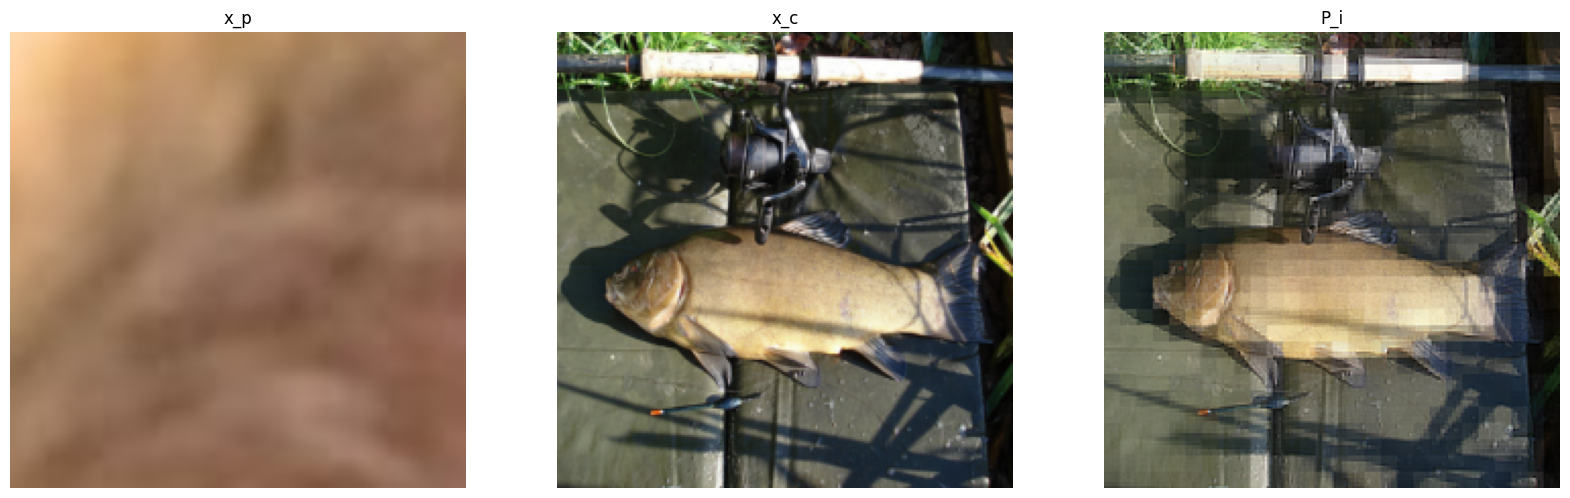

-0.44345588231061717

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(x_p)
axs[0].set_title('x_p')
axs[0].axis('off')

axs[1].imshow(x_c)
axs[1].set_title('x_c')
axs[1].axis('off')

axs[2].imshow(P_i)
axs[2].set_title('P_i')
axs[2].axis('off')

plt.show()
(P_i - x_c).sum()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


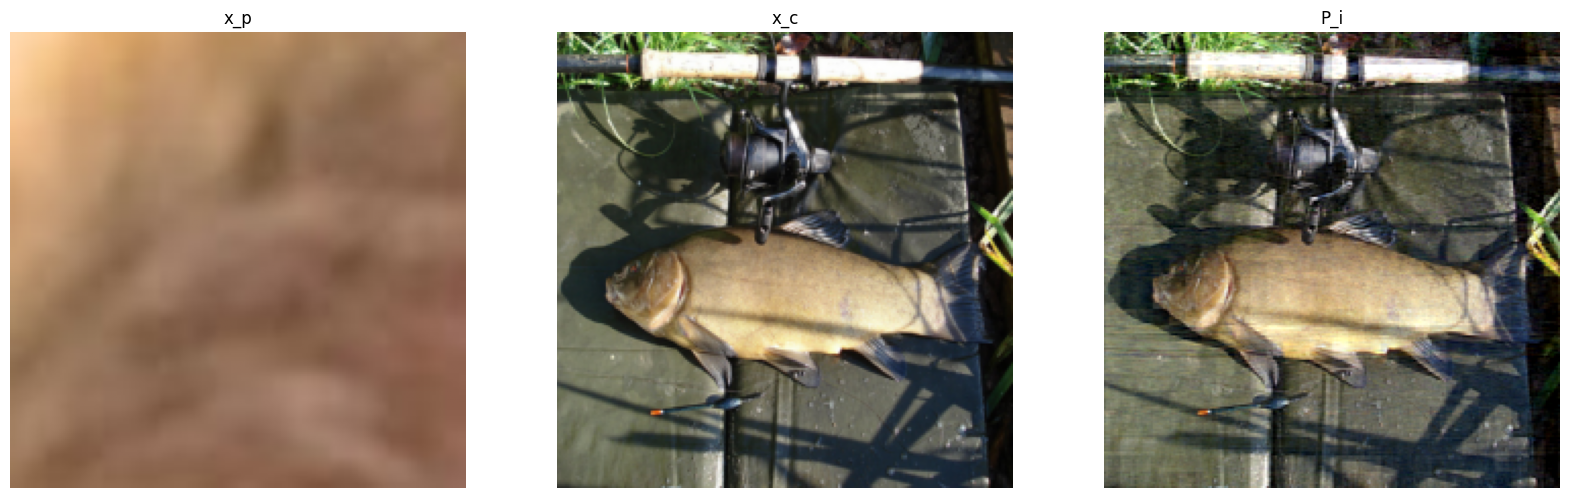

-2.9785618416156012e-12

In [56]:
x_c_f = fft_2d_3c(x_c)
clean_amp, clean_pha = np.abs(x_c_f), np.angle(x_c_f)
P_i_f = fft_2d_3c(P_i)
poison_amp, poison_phase = np.abs(P_i_f), np.angle(P_i_f)
P_i_f = clean_amp * np.exp(1j * poison_phase)
P_i = ifft_2d_3c(P_i_f).real

_, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(x_p)
axs[0].set_title('x_p')
axs[0].axis('off')

axs[1].imshow(x_c)
axs[1].set_title('x_c')
axs[1].axis('off')

axs[2].imshow(P_i)
axs[2].set_title('P_i')
axs[2].axis('off')

plt.show()
(P_i - x_c).sum()

### another api to mix high-frequency on clean image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


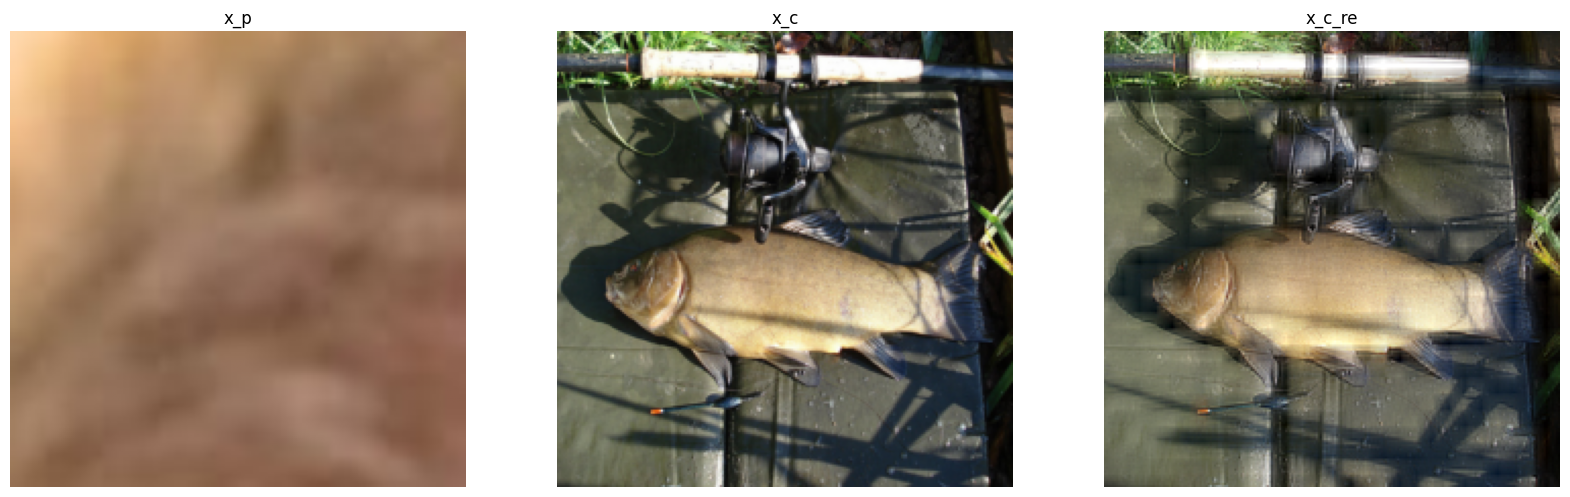

In [57]:
wave = 'db2'
alpha = 0.4

# do 3-level dwt for x_c
x_c_re = np.zeros_like(x_c)
for i in range(3):  # 3 channel
    L_1, (H_11, H_12, H_13) = pywt.dwt2(x_c[:, :, i], wave)
    L_2, (H_21, H_22, H_23) = pywt.dwt2(L_1, wave)
    L_3, (H_31, H_32, H_33) = pywt.dwt2(L_2, wave)
    
    x_p1 = np.array(x_p_img.resize((L_1.shape[0], L_1.shape[1]))) / 255.
    _, (HP_21, HP_22, HP_23) = pywt.dwt2(x_p1[:, :, i], wave)
    x_p2 = np.array(x_p_img.resize((L_2.shape[0], L_2.shape[1]))) / 255.
    _, (HP_31, HP_32, HP_33) = pywt.dwt2(x_p2[:, :, i], wave)
    
    H_21 = beta * H_21 + (1 - beta) * HP_21
    H_22 = beta * H_22 + (1 - beta) * HP_22
    H_23 = beta * H_23 + (1 - beta) * HP_23
    
    H_31 = alpha * H_31 + (1 - alpha) * HP_31
    H_32 = alpha * H_32 + (1 - alpha) * HP_32
    H_33 = alpha * H_33 + (1 - alpha) * HP_33
    
    res_coe = [L_3, (H_31, H_32, H_33), (H_21, H_22, H_23), (H_11, H_12, H_13)]
    x_c_re[:, :, i] = pywt.waverec2(coeffs=res_coe, wavelet=wave)
    

_, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(x_p)
axs[0].set_title('x_p')
axs[0].axis('off')

axs[1].imshow(x_c)
axs[1].set_title('x_c')
axs[1].axis('off')

axs[2].imshow(x_c_re)
axs[2].set_title('x_c_re')
axs[2].axis('off')
plt.show()

### exchange the amplitude of FFT and plot final results

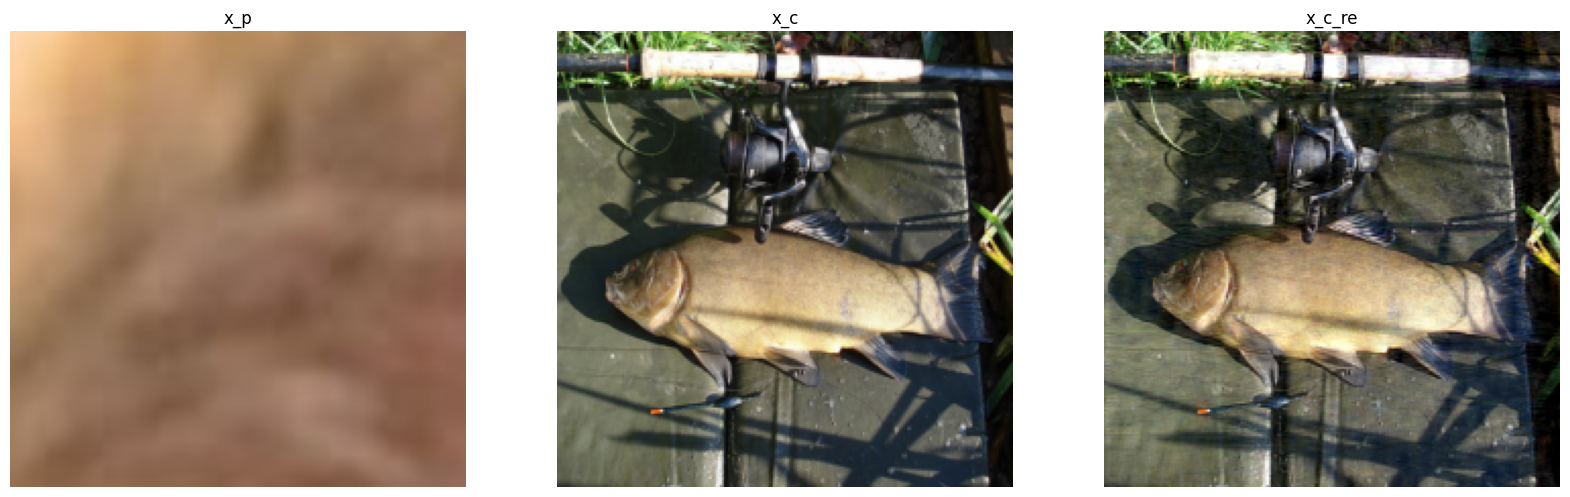

0.00010967050368704437

In [58]:
# exchange amplitude directly will induce bad results!
x_c_re_f = fft_2d_3c(x_c_re)
poison_amp, poison_pha = np.abs(x_c_re_f), np.angle(x_c_re_f)
x_c_f = fft_2d_3c(x_c)
clean_amp, clean_pha = np.abs(x_c_f), np.angle(x_c_f)
x_c_re_f = clean_amp * np.exp(1j * poison_pha)
x_c_re = ifft_2d_3c(x_c_re_f).real
x_c_re = np.clip(x_c_re, 0, 1)

_, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(x_p)
ax[0].set_title('x_p')
ax[0].axis('off')
ax[1].imshow(x_c)
ax[1].set_title('x_c')
ax[1].axis('off')
ax[2].imshow(x_c_re)
ax[2].set_title('x_c_re')
ax[2].axis('off')
plt.show()

(x_c_re - x_c).mean()


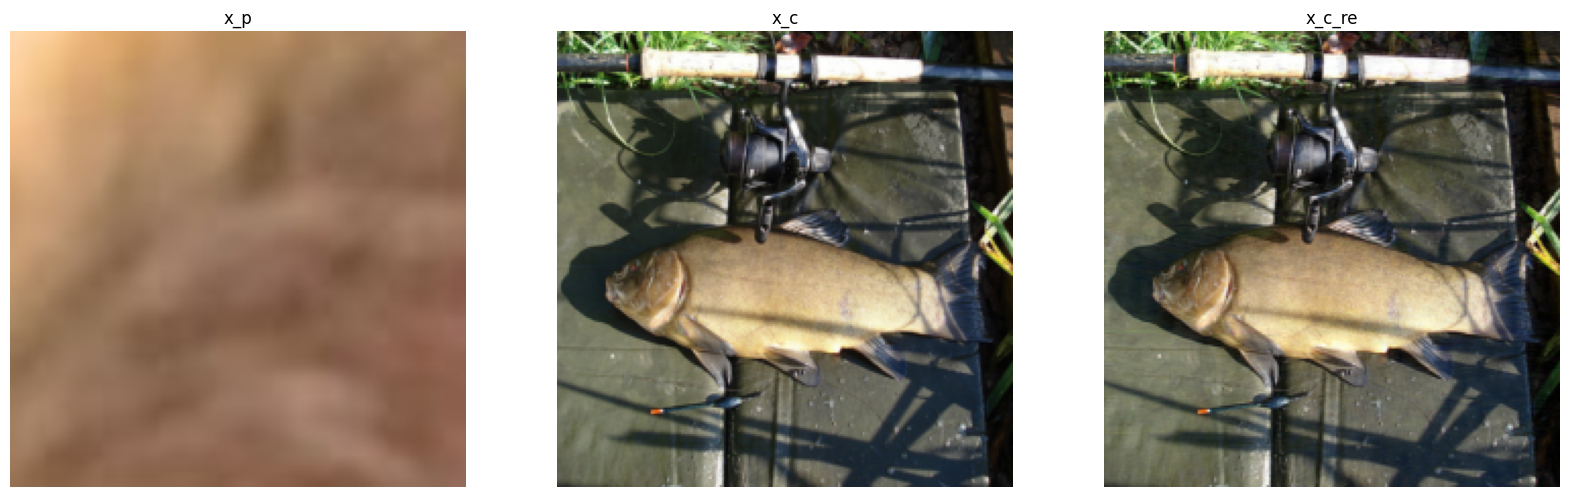

5.373854680673091e-05

In [59]:
lbd = 0.7
x_c_dct_1 = dct_2d_3c_slide_window(x_c.astype(float))
x_c_dct_2 = dct_2d_3c_slide_window(x_c_dct_1.astype(float))
x_c_re_dct_1 = dct_2d_3c_slide_window(x_c_re.astype(float))
x_c_re_dct_2 = dct_2d_3c_slide_window(x_c_re_dct_1.astype(float))
x_c_re_dct_2 = lbd * x_c_re_dct_2 + (1 - lbd) * x_c_dct_2
x_c_re_dct_1 = idct_2d_3c_slide_window(x_c_re_dct_2)
x_c_re_dct_1 = lbd * x_c_re_dct_1 + (1 - lbd) * x_c_dct_1
x_c_re = idct_2d_3c_slide_window(x_c_re_dct_1)

x_c_re = np.clip(x_c_re, 0, 1)

_, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(x_p)
ax[0].set_title('x_p')
ax[0].axis('off')
ax[1].imshow(x_c)
ax[1].set_title('x_c')
ax[1].axis('off')
ax[2].imshow(x_c_re)
ax[2].set_title('x_c_re')
ax[2].axis('off')
plt.show()

(x_c_re - x_c).mean()